In [89]:
import numpy as np
import matplotlib.pyplot as plt
import math, random
%matplotlib inline

In [2]:
def f(x):
  return 3*x**2 -4*x + 5

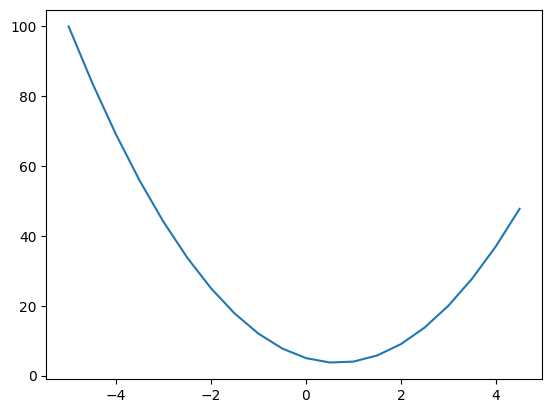

In [3]:
xs = np.arange(-5, 5, 0.5)
ys = f(xs)
plt.plot(xs, ys)

**derivative** at t can be computed by (f(x+h) - f(x)) / h, h being close to zero

In [69]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(Data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += out.grad
      other.grad += out.grad
    out._backward = _backward

    return out

  def __neg__(self):
    return self * -1

  def __sub__(self, other):
    return self + (-other);

  def __radd__(self, other):
    return self + other

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __rmul__(self, other):
    return self * other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out =  Value(t, (self,), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def __truediv__(self, other):
    return self * other**-1

  def exp(self):
    x = self.data
    t = math.exp(x)
    out = Value(t, (self,), 'exp')

    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward

    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float))
    out = Value(self.data**other, (self,), f"**{other}")

    def _backward():
      self.grad += other * (self.data**(other-1)) * out.grad
    out._backward = _backward

    return out

  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

## mini example of Value class

In [51]:
a = Value(2.0, label='a')
b = Value(-3, label='b')
c = Value(10, label='c')
e = a * b; e.label='e'
d = e + c; d.label='d'
f = Value(-2, label='f')
L = f * d; L.label = 'L'

print(d)
print(d._prev)
print(d._op)

Value(Data=4.0)
{Value(Data=10), Value(Data=-6.0)}
+


In [52]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

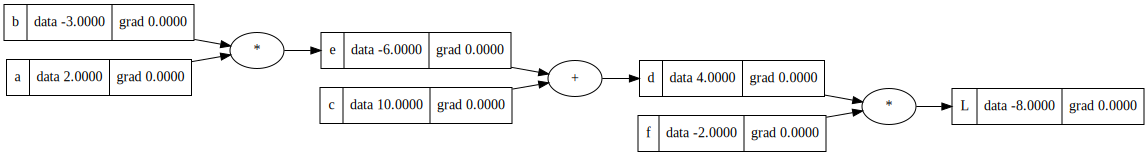

In [53]:
draw_dot(L)

In [54]:
L.grad = 1.0

## try to set grad by chain rules manually

## simple neuron example

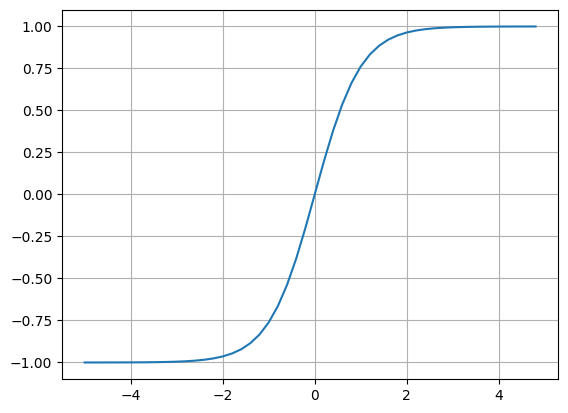

In [55]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2)))
plt.grid()

In [75]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

b = Value(6.8813735870195432, label='b')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

w1x1 = w1*x1; w1x1.label='w1x1'
w2x2 = w2*x2; w2x2.label='w2x2'

wx = w1x1 + w2x2; wx.label='wx'

n = wx + b; n.label='n'

#######
#o = n.tanh(); o.label='o'
#######

e = (2*n).exp(); e.label='e';
o = (e - 1)/(e + 1); o.label = 'o'

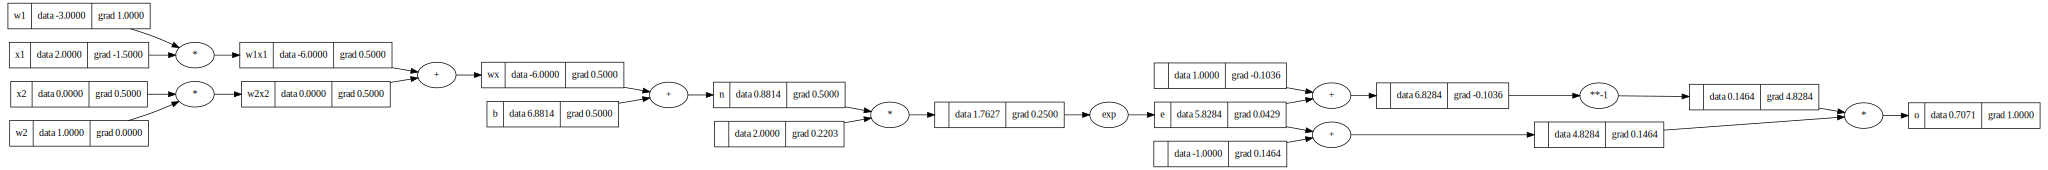

In [78]:
draw_dot(o)

In [58]:
## this is very manual. will improve this
# o.grad = 1.0

# n.grad = 1-o.data**2 # see derivative of tanh(x) = 1 - tanh^2(x)

# # derivate of '+' connected just flows back as it is. try to see urself (along with chain rule)
# b.grad = n.grad
# wx.grad = n.grad

# w1x1.grad = wx.grad
# w2x2.grad = wx.grad

# w2.grad = w2x2.grad * x2.data
# x2.grad = w2x2.grad * w2.data
# w1.grad = w1x1.grad * x1.data
# x1.grad = w1x1.grad * w1.data

In [59]:
# o.grad = 1.0
# o._backward()
# n._backward()
# wx._backward()
# b._backward()
# w2x2._backward()
# w1x1._backward()

In [77]:
o.backward()

In [61]:
import inspect as i
import sys
sys.stdout.write(i.getsource(n._backward))

    def _backward():
      self.grad += out.grad
      other.grad += out.grad


In [79]:
import torch

In [88]:
x1 = torch.Tensor([2.0]).double();                      x1.requires_grad = True
w1 = torch.Tensor([-3.0]).double();                     w1.requires_grad = True
x2 = torch.Tensor([0.0]).double();                      x2.requires_grad = True
w2 = torch.Tensor([1.0]).double();                      w2.requires_grad = True
b  = torch.Tensor([6.8813735870195432]).double();        b.requires_grad = True

n = w1*x1 + w2*x2 + b
o = torch.tanh(n)

print(o.data.item())

o.backward()

print('x2 grad', x2.grad.item())
print('w2 grad', w2.grad.item())
print('x1 grad', x1.grad.item())
print('w1 grad', w1.grad.item())
print('b grad', b.grad.item())

0.7071066904050358
x2 grad 0.5000001283844369
w2 grad 0.0
x1 grad -1.5000003851533106
w1 grad 1.0000002567688737
b grad 0.5000001283844369


## Neuron, Layer and MLP

In [162]:
class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1, 1))

  def __call__(self, x):
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    return act.tanh()

  def parameters(self):
    return self.w + [self.b]

class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [177]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
o = n(x)
print(o)

Value(Data=0.5457922853925344)


In [178]:
xs = [
    [2.0,3.0,-1.0],
    [3.0,-1.0,0.5],
    [0.5,1.0,1.0],
    [1.0,1.0,-1.0],
]
ys = [1.0,-1.0,-1.0,1.0]
#ypred = [n(x) for x in xs]
#ypred

In [179]:
# ypred = [n(x) for x in xs]
# loss = sum([(yo - ys)**2 for ys, yo in zip(ys, ypred)])
# print(loss)

In [180]:
#draw_dot(loss)

In [181]:
#loss.backward()

In [182]:
#len(n.parameters())

In [183]:
# for p in n.parameters():
#   p.data += -0.01 * p.grad

In [192]:
for k in range(20):
  # forward
  ypred = [n(x) for x in xs]
  loss = sum([(yo - ys)**2 for ys, yo in zip(ys, ypred)])

  # backward
  for p in n.parameters():
    p.grad = 0
  loss.backward()

  # gradient update
  for p in n.parameters():
    p.data += -0.01 * p.grad

  print(k, loss.data)

0 0.003834006782113114
1 0.0038268659530538447
2 0.00381975115015181
3 0.003812662232227478
4 0.0038055990591174173
5 0.003798561491665268
6 0.0037915493917126987
7 0.003784562622090445
8 0.0037776010466095793
9 0.003770664530052722
10 0.0037637529381653817
11 0.0037568661376475537
12 0.0037500039961450827
13 0.003743166382241486
14 0.003736353165449545
15 0.003729564216203178
16 0.003722799405849337
17 0.0037160586066399934
18 0.0037093416917242353
19 0.0037026485351403706


In [193]:
ypred

[Value(Data=0.979861354951276),
 Value(Data=-0.9726273654975401),
 Value(Data=-0.9664948371993716),
 Value(Data=0.9622478284486838)]